<a href="https://colab.research.google.com/github/Jaime-Simoes/DL_project/blob/main/Copy_of_DL_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
# to put all the imports necessary

import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import requests
import os
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from multiprocessing import Pool
from google.colab import files
import logging
import time

In [182]:
df = pd.read_csv('fitzpatrick17k.csv')

In [183]:
# get names of columns

columns = df.columns.tolist()
print(columns)

['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum']


In [184]:
print(len(df))      # amount of occurences

16577


In [185]:
df.isnull().sum()     # missing values

md5hash                      0
fitzpatrick_scale            0
fitzpatrick_centaur          0
label                        0
nine_partition_label         0
three_partition_label        0
qc                       16073
url                         41
url_alphanum                 0
dtype: int64

In [186]:
df.isna().sum()

md5hash                      0
fitzpatrick_scale            0
fitzpatrick_centaur          0
label                        0
nine_partition_label         0
three_partition_label        0
qc                       16073
url                         41
url_alphanum                 0
dtype: int64

In [187]:
print(df.duplicated(subset=['md5hash']).sum())

# First column has no repeated values. It's codes of some sort to identify each occurence.
# So we can delete this column.

0


In [188]:
df.drop(columns=['md5hash'], inplace=True)

In [189]:
# qc might be quality control

In [190]:
print(df['qc'].value_counts())     # numbers before are part of the names

# need to discuss this, not sure what's going on

1 Diagnostic          348
5 Potentially          97
2 Characteristic       32
3 Wrongly labelled     17
4 Other                10
Name: qc, dtype: int64


In [191]:
print(df['label'].value_counts())      # our target variable. lenght = 114 ;

psoriasis                      653
squamous cell carcinoma        581
lichen planus                  491
basal cell carcinoma           468
allergic contact dermatitis    430
                              ... 
port wine stain                 59
erythema elevatum diutinum      55
pustular psoriasis              53
xanthomas                       53
pilomatricoma                   53
Name: label, Length: 114, dtype: int64


In [192]:
duplicate_url = df.duplicated(subset=['url'])
print(duplicate_url.value_counts())

# 40 url repeat. Let's see if the whole line is equal (except 1st column that is some weird code)

False    16537
True        40
dtype: int64


In [193]:
print(df.iloc[:, 1:].duplicated().sum())     # duplicate rows except first column

# so there are 40 repeated url but no repeated rows. Meaning equal pictures have
# different attributes. need to discuss this.

0


In [194]:
print(df.iloc[:, [i for i in range(len(df.columns)) if i not in [0, 6]]].duplicated().sum())

0


In [195]:
print(df['nine_partition_label'].value_counts())
# categorize skin conditions by 9

inflammatory                    10886
malignant epidermal              1352
genodermatoses                   1194
benign dermal                    1067
benign epidermal                  931
malignant melanoma                573
benign melanocyte                 236
malignant cutaneous lymphoma      182
malignant dermal                  156
Name: nine_partition_label, dtype: int64


In [196]:
print(df['three_partition_label'].value_counts())
# categorize skin conditions by 3

non-neoplastic    12080
malignant          2263
benign             2234
Name: three_partition_label, dtype: int64


In [197]:
# Get distributions of numerical columns

In [198]:
# "fitzpatrick_scale" -> classification system used to categorize human skin color based on its response to sun exposure or UV light.
# Scale is from 1 to 6. (-1) instances are missing values.

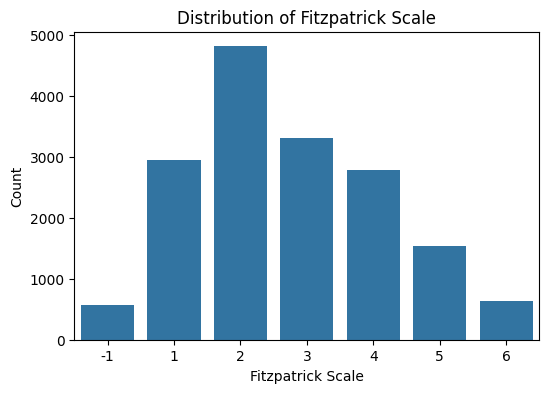

In [199]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fitzpatrick_scale')
plt.title('Distribution of Fitzpatrick Scale')
plt.xlabel('Fitzpatrick Scale')
plt.ylabel('Count')
plt.show()

In [200]:
# Need to discuss what to do with these missing values!

In [201]:
missing_fitzscale = df[df['fitzpatrick_scale'] == -1]
print(missing_fitzscale['fitzpatrick_centaur'].value_counts())

# big correlation between missing values of fitz columns. The other values follow the
# reference distribution, aka proportional to existing values.

-1    291
 2     87
 1     75
 4     34
 3     33
 5     31
 6     14
Name: fitzpatrick_centaur, dtype: int64


In [202]:
print(missing_fitzscale['nine_partition_label'].value_counts())

# Here is a bit off but not mutch.

inflammatory                    359
malignant epidermal              65
benign dermal                    49
genodermatoses                   29
malignant melanoma               27
benign epidermal                 22
malignant cutaneous lymphoma      6
malignant dermal                  5
benign melanocyte                 3
Name: nine_partition_label, dtype: int64


In [203]:
print(missing_fitzscale['three_partition_label'].value_counts())

# Also different.

non-neoplastic    388
malignant         103
benign             74
Name: three_partition_label, dtype: int64


In [204]:
# "fitzpatrick_centaur" -> don't know what this is. Most likely (-1) are also missing values.

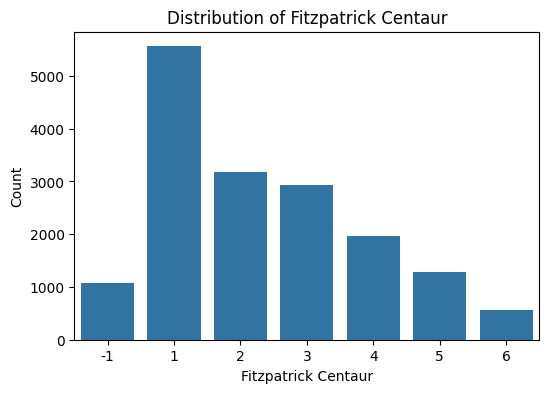

In [205]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fitzpatrick_centaur')
plt.title('Distribution of Fitzpatrick Centaur')
plt.xlabel('Fitzpatrick Centaur')
plt.ylabel('Count')
plt.show()

In [206]:
# Need to discuss what to do with these missing values!

In [207]:
missing_fitzcentaur = df[df['fitzpatrick_centaur'] == -1]
print(missing_fitzcentaur['nine_partition_label'].value_counts())

# Different from scale column.

inflammatory                    661
benign dermal                   159
malignant epidermal             122
benign epidermal                 52
malignant melanoma               31
genodermatoses                   26
malignant dermal                 11
benign melanocyte                10
malignant cutaneous lymphoma      1
Name: nine_partition_label, dtype: int64


In [208]:
print(missing_fitzcentaur['three_partition_label'].value_counts())

non-neoplastic    687
benign            221
malignant         165
Name: three_partition_label, dtype: int64


In [209]:
# Now let's apply one hot encoding for categorical variables

In [210]:
one_hot_encode = ["label", "nine_partition_label", "three_partition_label"]

new_df = pd.get_dummies(df, columns=one_hot_encode)

In [211]:
new_df.head()

,fitzpatrick_scale,fitzpatrick_centaur,qc,url,url_alphanum,label_acanthosis nigricans,label_acne,label_acne vulgaris,label_acquired autoimmune bullous diseaseherpes gestationis,label_acrodermatitis enteropathica,...,nine_partition_label_benign melanocyte,nine_partition_label_genodermatoses,nine_partition_label_inflammatory,nine_partition_label_malignant cutaneous lymphoma,nine_partition_label_malignant dermal,nine_partition_label_malignant epidermal,nine_partition_label_malignant melanoma,three_partition_label_benign,three_partition_label_malignant,three_partition_label_non-neoplastic
0,3,3,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,2,3,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,1,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [212]:
new_df.shape

(16577, 131)

In [213]:
# This will give problems later on for sure but for now keep it like this. To apply CNN needs to be one hot encoded.

In [214]:
# Need to see if column "qc" is built in a certain specific way that makes sense. If not almost everything is missing values so it
# will be worse to keep it I think. Delete for now:

In [215]:
new_df.drop(columns=['qc'], inplace=True)

In [216]:
# Let's deal with the missing values in url. url_alphanum doesn't have any.

In [217]:
new_df['url'].fillna(df['url_alphanum'], inplace=True)

In [218]:
print(new_df['url'].isnull().sum())

0


In [219]:


# Filter rows where 'url' column has been filled with values from 'url_alphanum'
filled_rows = new_df['url'] == new_df['url_alphanum']
print(new_df.loc[filled_rows, 'url'])

145      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
349      httpwwwdermaamincomsiteimagesclinicalpicooralm...
535      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
868      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
879      httpwwwdermaamincomsiteimagesclinicalpicooralm...
918      httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1322     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
1958     httpwwwdermaamincomsiteimageshistopicjjunction...
1972     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2078     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
2519     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3601     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
3672     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4267     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4426     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
4795     httpwwwdermaamincomsiteimagesclinicalpicLLiche...
5410     httpwwwdermaamincomsiteimagesclinicalpicLLiche.

In [220]:
# Define the function to convert the URL
def convert_url(url):
    url = url.replace("httpwwwdermaamincom", "https://www.dermaamin.com")
    url = url.replace("siteimages", "site/images/")
    url = url.replace("clinicalpicLLichensimplexchronicusLichensimplexchronicus", "clinical-pic/l/lichensimplexchronicus/lichensimplexchronicus")
    url = url.replace("site/images/l/", "site/images/")
    url = url.replace("jpg.jpg", ".jpg")
    url = url.replace("jpg", "jpg")
    url = url.replace("com", "com/")
    return url

# Apply the conversion function to the filtered rows
df_3 = new_df.copy()  # Create a copy of the DataFrame to avoid modifying the original
df_3.loc[filled_rows, 'url'] = df_3.loc[filled_rows, 'url'].apply(convert_url)

# Print the modified 'url' column
print(df_3.loc[filled_rows, 'url'])

145      https://www.dermaamin.com/site/images/clinical...
349      https://www.dermaamin.com/site/images/clinical...
535      https://www.dermaamin.com/site/images/clinical...
868      https://www.dermaamin.com/site/images/clinical...
879      https://www.dermaamin.com/site/images/clinical...
918      https://www.dermaamin.com/site/images/clinical...
1322     https://www.dermaamin.com/site/images/clinical...
1958     https://www.dermaamin.com/site/images/histopic...
1972     https://www.dermaamin.com/site/images/clinical...
2078     https://www.dermaamin.com/site/images/clinical...
2519     https://www.dermaamin.com/site/images/clinical...
3601     https://www.dermaamin.com/site/images/clinical...
3672     https://www.dermaamin.com/site/images/clinical...
4267     https://www.dermaamin.com/site/images/clinical...
4426     https://www.dermaamin.com/site/images/clinical...
4795     https://www.dermaamin.com/site/images/clinical...
5410     https://www.dermaamin.com/site/images/clinical.

In [221]:
def download_image(image_url, file_place):
    """
    Downloads images from URLs.

    Inputs:
        image_url(str): URL of the image to download.
        file_place(str): Path where the downloaded image will be saved.

    Outputs:
        None.
    """
    # Step 1: Send a GET request to the provided image URL
    res = requests.get(image_url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})

    # Step 2: Check if the request was successful (HTTP status code 200)
    if res.status_code == 200:
        # Step 3: If successful, open the file at the specified location in binary write mode
        with open(file_place, 'wb') as f:
          shutil.copyfileobj(res.raw, f) # Step 4: Copy the content of the response to the file
        # Step 5: Print the status of the download

    else:
        print("Image coulnd't be retrieved")

In [222]:
# Download locally so that you don't have to download everything every time you leave.

In [225]:
def download_image(image_url, file_place):
    """
    Downloads images from URLs.

    Inputs:
        image_url(str): URL of the image to download.
        file_place(str): Path where the downloaded image will be saved.

    Outputs:
        None.
    """
    try:
        # Create the output directory if it doesn't exist
        os.makedirs(os.path.dirname(file_place), exist_ok=True)

        # Send a GET request to the provided image URL
        res = requests.get(image_url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})

        # Check if the request was successful (HTTP status code 200)
        if res.status_code == 200:
            # Open the file at the specified location in binary write mode
            with open(file_place, 'wb') as f:
                shutil.copyfileobj(res.raw, f)  # Copy the content of the response to the file

        else:
            print(f"Failed to download image from {image_url}")
    except Exception as e:
        print(f"Error downloading image from {image_url}: {e}")

In [ ]:

# Assuming df_3 is your DataFrame containing image URLs
url_column_name = 'url'
output_folder = 'images_DL'  # folder where to save downloaded images
download_images_from_csv(df_3, url_column_name, output_folder)

Failed to download image from https://www.dermaamin.com/site/images/clinical-pic/l/lichensimplexchronicus/lichensimplexchronicus30.jpg
Failed to download image from https://www.dermaamin.com/site/images/clinicalpicooralmucosalmelanomaoralmucosalmelanoma2.jpg


In [ ]:
# Define the directory to be zipped
directory_to_zip = '/content/images_DL'  # Change this to your directory path

# Define the name for the zip file
zip_file_name = 'project_pic.zip'

# Create a zip file containing the directory
shutil.make_archive(zip_file_name, 'zip', directory_to_zip)

# Define the destination directory
destination_directory = r'fuck_this'

# Move the zip file to the destination directory
shutil.move(zip_file_name + '.zip', destination_directory)

'fuck_this'

In [ ]:
# Rows being skipped are the ones that had the url replaced. Maybe new url is wrong or there is just on picture for those rows.
# Discuss if we can just delete those rows. About 40 in the whole dataset.